In [18]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn

# Import price data of goldman sachs

In [20]:
Citi = pd.read_pickle('../data/pricedata/C_2007-05-022015-12-31')
GS  = pd.read_pickle('../data/pricedata/GS_2007-05-022015-12-31')

In [21]:
spread = pd.DataFrame()
spread['ratio'] = Citi.Close/GS.Close
spread['pastratio'] = pd.rolling_mean(spread.ratio, 100)

In [22]:
data = pd.read_pickle('../data/pricedata/C_2007-05-022015-12-31')['Close'] - pd.read_pickle('../data/pricedata/GS_2007-05-022015-12-31')['Close']

data['rol_std'] = pd.rolling_std(data, 100)

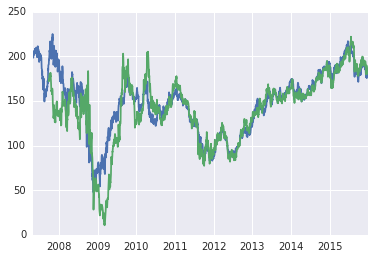

In [23]:
plot(GS.Close)
plot(Citi.Close/spread.pastratio.shift(1))

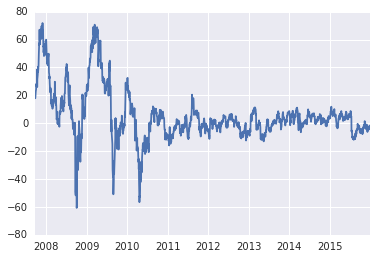

In [24]:
plot(GS.Close-Citi.Close/spread.pastratio.shift(1))

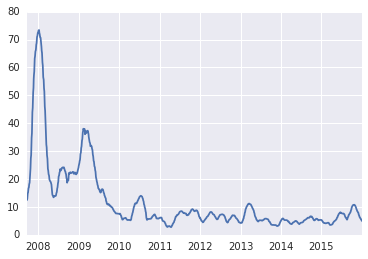

In [25]:
#This is what we're looking at

plt.plot(data.rol_std)

In [26]:
# I have a time series of the percentage returns/100 for each day. This is what I will use to compute the strategy's return

def get_dailyret(ser):
    return (ser.shift(-1) - ser)/ser

data['dailyrets'] = get_dailyret(data.Close)

AttributeError: 'Series' object has no attribute 'Close'

# Kalman Filter
I will store the data from the filter in the dataframe

First I define some simple functions

In [ ]:
#TODO document every line of this

import filterpy as fp
from filterpy.kalman import predict, update
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import KalmanFilter


def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]]) #init location and velocity
    kf.F = np.array([[1, dt],
                     [0,  1]])    # state transition matrix
    kf.H = np.array([[1, 0]])     # Measurement function
    kf.R *= R                   # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        kf.Q = Q
    return kf



def run(x0=(200.,0.), P=500, R=0, Q=0, dt=1.0, data=None,
        count=0, do_plot=True, **kwargs):
    """
    `data` is a 2D numpy array; the first column contains
    the actual position, the second contains the measurements
    """

    # create the Kalman filter
    kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)  

    # run the kalman filter and store the results
    xs, cov = [], []
    for n in range(data.shape[0]):
        row = data.iloc[n]
        z = row['Close']
        
        kf.predict( )
        
        
        R = row.rol_std*1         #(float(row['High'])-float(row['Low']))*2
        kf.update(z, R =R)
        
        xs.append(kf.x)
        cov.append(kf.P)
        
        
    xs, cov = np.array(xs), np.array(cov)
    
    return xs, cov


I call the function and store the data. Note that here is where I chose the variance attribute for the Q variable

In [ ]:
data = data.dropna()
xs , cov = run(P=500, Q=0.000035, data=data)
data['kal_mean'], data['kal_vel'], data['kal_pricecov'], data['kal_velcov'] = xs[:,0], xs[:,1], cov[:,0][:,0], cov[:,1][:,1]
    

In [ ]:
from filterpy.stats import plot_covariance_ellipse

In [ ]:
print(xs[400], cov[400])
predict(xs[400], cov[400], np.array([[1,1],[0,1]]), Q_discrete_white_noise(dim=2, dt=1, var=.05))

In [ ]:
for i in range(100,110):
    plot_covariance_ellipse(xs[i],cov[i])
    x, P = predict(xs[i], cov[i], np.array([[1,1],[0,1]]), Q_discrete_white_noise(dim=2, dt=1, var=.05))
    plot_covariance_ellipse(x,P)
    show()#, edgecolor='r')

In [27]:
cov

<function numpy.lib.function_base.cov>

And here I process it in several ways

In [28]:
# the prediction's formula is p = m + v(dt)
data['kal_predict']  = data.kal_mean + data.kal_vel
# a residual between what tomorrow's predicted value is and today's price
data['kal_res'] = data.kal_predict - data.Close
# a rolling standard deviation of the residual to use as part of the threshold
data['rol_std'] = pd.rolling_std(data.kal_res, 100)
# The logic for the trade. Note how some coefficients are zero. I dont really know how they all fit together yet
data['kal_returns'] = (
    abs(data.kal_res) - data.kal_pricecov*0 + data.kal_velcov*0 > (data.rol_std*2- data.kal_pricecov*.5)  
                      ) * sign(data.kal_res)*data.dailyrets
# a cumulative product to get the equity curve
data['kal_eq_curve'] = np.cumprod(data.kal_returns+1)

AttributeError: 'Series' object has no attribute 'kal_mean'

In [29]:
# this is the filter's prediction, it follows the price very closely. 
plt.plot(data.Close[100:])
plt.plot(data.kal_predict[100:])

AttributeError: 'Series' object has no attribute 'Close'

In [30]:
# finally, we have the equity curve
plt.plot(data.kal_eq_curve)

AttributeError: 'Series' object has no attribute 'kal_eq_curve'

In [31]:
#and here's what I think is the envelope chart that you wanted 
plt.plot(data.Close[-100:], c='b')
plt.plot(data.kal_predict[-100:], c='r')
#plt.plot(data.kal_mean[-100:], c= 'g')
plt.plot(data.kal_predict[-100:]+data.kal_pricecov[-100:])
plt.plot(data.kal_predict[-100:]-data.kal_pricecov[-100:])
plt.show()
plt.plot(data.kal_pricecov[-100:])
plt.plot(data.kal_eq_curve[-100:])
plt.show()
plt.plot(data.rol_std[-100:])

AttributeError: 'Series' object has no attribute 'Close'

In [32]:
#Trying a different version of the threshold
plt.plot(data.Close[-100:], c='b')
plt.plot(data.kal_predict[-100:], c='r')
#plt.plot(data.kal_mean[-100:], c= 'g')
plt.plot(data.kal_predict[-100:]+data.kal_pricecov[-100:])
plt.plot(data.kal_predict[-100:]-data.kal_pricecov[-100:])
plt.show()


AttributeError: 'Series' object has no attribute 'Close'

In [33]:
# the prediction's formula is p = m + v(dt)
data['kal_predict']  = data.kal_mean + data.kal_vel
# a residual between what tomorrow's predicted value is and today's price
data['kal_res'] = data.kal_predict - data.Close
# a rolling standard deviation of the residual to use as part of the threshold
data['rol_std'] = pd.rolling_std(data.kal_res, 100)
# The logic for the trade. Note how some coefficients are zero. I dont really know how they all fit together yet
data['kal_returns'] = (
    abs(data.kal_res) - data.kal_pricecov*0 + data.kal_velcov*0 > (data.rol_std*data.kal_pricecov*data.kal_velcov*50)  
                      ) * sign(data.kal_res)*data.dailyrets
# a cumulative product to get the equity curve
data['kal_eq_curve'] = np.cumprod(data.kal_returns+1)

AttributeError: 'Series' object has no attribute 'kal_mean'

In [34]:
plot(data.kal_eq_curve)

AttributeError: 'Series' object has no attribute 'kal_eq_curve'

In [35]:
plot(data.kal_eq_curve)

AttributeError: 'Series' object has no attribute 'kal_eq_curve'

In [36]:
tradedata = data[data.kal_returns != 0]

AttributeError: 'Series' object has no attribute 'kal_returns'

In [37]:
?plt.scatter

In [38]:
plt.scatter( tradedata.kal_res-(sign(tradedata.kal_res)*tradedata.rol_std*2), tradedata.kal_returns )
plt.scatter( tradedata.kal_res-(sign(tradedata.kal_res)* (tradedata.rol_std*2 + tradedata.kal_pricecov*.5)),
                                tradedata.kal_returns, c='r' )


NameError: name 'tradedata' is not defined

In [39]:
plt.scatter( tradedata.kal_res-(sign(tradedata.kal_res)*tradedata.rol_std*2), tradedata.kal_returns )
plt.scatter( tradedata.kal_res-(sign(tradedata.kal_res)* (tradedata.rol_std*2 + tradedata.kal_pricecov)),
                                tradedata.kal_returns, c='r' )


NameError: name 'tradedata' is not defined

In [40]:
data.columns

AttributeError: 'Series' object has no attribute 'columns'

In [41]:
plot(tradedata.kal_pricecov)
plot(data.kal_pricecov[100:])
plot(tradedata.cov_idea)

NameError: name 'tradedata' is not defined

In [42]:
plt.scatter(tradedata.cov_idea, tradedata.kal_returns)

NameError: name 'tradedata' is not defined

In [ ]:
data['cov_idea'] = pd.rolling_mean(data.kal_pricecov, 20)- data.kal_pricecov